# Taller 2 - Embeddings, clasificación de texto y fine-tuning

Integrantes:

- Carlos Daniel Corrales Arango (2122878)
- Jose Manuel Palma Oquendo (2125182)

# Punto 2: Embeddings de oraciones

Procesar documentos PDF, generar representaciones vectoriales de sus fragmentos mediante modelos de Sentence Transformers de Hugging Face y comparar el desempeño de distintos modelos en la recuperación semántica de texto mediante similitud coseno.

## 2.1 Carga y procesamiento de documentos PDF

Se descargan los archivos PDF desde una carpeta compartida en Google Drive y se leen utilizando PyMuPDF4LLMLoader de LangChain, un cargador recomendado por su capacidad para preservar el layout y el contenido original de los documentos.

In [ ]:
# 1. CONFIGURACIÓN INICIAL Y CONEXIÓN A GOOGLE DRIVE
import os
import shutil
import gdown

In [ ]:
# 2. INSTALACIÓN DE LIBRERÍAS
!pip install -q langchain sentence-transformers pymupdf4llm torch scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 56.5 MB/s eta 0:00:00


In [ ]:
# Configurar ruta de salida para PDFs
PDF_FOLDER = '/content/pdfs'
os.makedirs(PDF_FOLDER, exist_ok=True)

# URL de la carpeta compartida de los PDFs
FOLDER_URL = 'https://drive.google.com/drive/folders/1-B5tfTIa6znq3SOQXl5uLKKv_uYNsXe-'

print(f"\n Carpeta compartida: {FOLDER_URL}")
print("Descargando PDFs...")

# Intentar descargar la carpeta completa
try:
    gdown.download_folder(FOLDER_URL, output=PDF_FOLDER, quiet=False, remaining_ok=True)
    print("\nDescarga completada")
except Exception as e:
    print(f"\nError al descargar: {e}")


 Carpeta compartida: https://drive.google.com/drive/folders/1-B5tfTIa6znq3SOQXl5uLKKv_uYNsXe-
Descargando PDFs...


Retrieving folder contents


Retrieving folder 1N6BxSUTxP_lHM0Rw1abfr9qOVxsByPjJ .ipynb_checkpoints
Processing file 1KGy03yOR3bflxk0aXKyBKyNgNlbZFCCc acreditación-2024-1-checkpoint.pdf
Processing file 1YPDuAnWYIpMY5CDzrLRbWsiMC-XTVjTS acreditación-2024-3-checkpoint.pdf
Processing file 15lrUGkOfJvcmcTb6GLUuQBwCmddj3ch0 acreditación-2024-5-checkpoint.pdf
Processing file 1Jz1EdkiKoEyxGqvgBKJoNo3HDDLTyWfU acreditación-2024-1.pdf
Processing file 1dps34Y0JRshoP6wwu4bzuyIeOEkybOuV acreditación-2024-2.pdf
Processing file 1bHXmBqwmmqoXBYaIjyR522R3vdXww331 acreditación-2024-3.pdf
Processing file 1AKN8hVmPvSvqcPusmq2LDxLzl2YKqu5w acreditación-2024-4.pdf
Processing file 1J99HMni9O66rxlQtFQg9zHRJdGRB-Xli acreditación-2024-5.pdf
Processing file 12dpMTwnXwLBYNm2qcxhXGzM7l9ACaZlc acreditación-2024-6.pdf
Processing file 15k0pqrniaiv7N8izJsNv4KTEnEA5OjQJ acreditación-2024-6.pdf.md
Processing file 1FS4Ygz0OyDVprMfNJwl0doxSPpznYCu5 acreditación-2024-7.pdf
Processing file 1WgaLbyLj81SufaC4r0zJWwfIqry6_BOD acreditación-2024-7.pdf.md
Pr

Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1KGy03yOR3bflxk0aXKyBKyNgNlbZFCCc
To: /content/pdfs/.ipynb_checkpoints/acreditación-2024-1-checkpoint.pdf
100%|██████████| 2.33M/2.33M [00:00<00:00, 14.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1YPDuAnWYIpMY5CDzrLRbWsiMC-XTVjTS
To: /content/pdfs/.ipynb_checkpoints/acreditación-2024-3-checkpoint.pdf
100%|██████████| 502k/502k [00:00<00:00, 56.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=15lrUGkOfJvcmcTb6GLUuQBwCmddj3ch0
To: /content/pdfs/.ipynb_checkpoints/acreditación-2024-5-checkpoint.pdf
100%|██████████| 740k/740k [00:00<00:00, 66.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Jz1EdkiKoEyxGqvgBKJoNo3HDDLTyWfU
To: /content/pdfs/acreditación-2024-1.pdf
100%|██████████| 2.33M/2.33M [00:00<00:00, 177MB/s]
Downloading...
From: https://drive.google.com/uc?id=1dps34Y0JRshoP6wwu4bzuyIeOEkybOuV



Descarga completada



Download completed


In [ ]:
# Verificar qué archivos .pdf se descargaron
archivos_pdf = []
for root, dirs, files in os.walk(PDF_FOLDER):
    for file in files:
        if file.lower().endswith('.pdf'):
            archivos_pdf.append(os.path.join(root, file))

print(f"\nRESUMEN DE DESCARGA:")
print(f"PDFs encontrados: {len(archivos_pdf)}")

if len(archivos_pdf) > 0:
    print(f"\nPrimeros 5 archivos:")
    for i, archivo in enumerate(archivos_pdf[:5], 1):
        nombre = os.path.basename(archivo)
        tamaño = os.path.getsize(archivo) // 1024
        print(f"   {i:2d}. {nombre} ({tamaño} KB)")
    if len(archivos_pdf) > 5:
        print(f"   ... y {len(archivos_pdf) - 5} más")
else:
    print("\nNo se encontraron PDFs. Revisa la carpeta o la URL.")


RESUMEN DE DESCARGA:
PDFs encontrados: 31

Primeros 5 archivos:
    1. arcusur-2.pdf (358 KB)
    2. arcusur-3.pdf (288 KB)
    3. acreditación-2024-4.pdf (6107 KB)
    4. arcusur-5.pdf (392 KB)
    5. acreditación-2024-8.pdf (4804 KB)
   ... y 26 más


In [ ]:
# 3. CARGA DE PDFs CON pymupdf4llm + LANGCHAIN
!pip install -qU langchain-pymupdf4llm
from langchain_pymupdf4llm import PyMuPDF4LLMLoader, PyMuPDF4LLMParser
import os

PDF_FOLDER = '/content/pdfs'
documentos = []

# Recorrer todos los archivos .pdf
archivos_pdf = []
for root, dirs, files in os.walk(PDF_FOLDER):
    for file in files:
        if file.lower().endswith('.pdf'):
            archivos_pdf.append(os.path.join(root, file))

for i, ruta_pdf in enumerate(archivos_pdf, 1):
    try:
        print(f"   {i:2d}/{len(archivos_pdf)}: {os.path.basename(ruta_pdf)}")
        loader = PyMuPDF4LLMLoader(ruta_pdf)
        docs = loader.load()  # Esto devuelve una lista de Document
        # Añadir metadato del nombre del archivo
        for doc in docs:
            doc.metadata["source"] = os.path.basename(ruta_pdf)
        documentos.extend(docs)
    except Exception as e:
        print(f"Error en {os.path.basename(ruta_pdf)}: {str(e)}")

print(f"\nTotal de documentos cargados: {len(documentos)}")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain 0.3.27 requires langchain-core<1.0.0,>=0.3.72, but you have langchain-core 1.0.5 which is incompatible.
    1/31: arcusur-2.pdf
    2/31: arcusur-3.pdf
    3/31: acreditación-2024-4.pdf
    4/31: arcusur-5.pdf
    5/31: acreditación-2024-8.pdf
    6/31: arcusur-7.pdf
    7/31: acreditación-2024-13.pdf
    8/31: acreditación-2024-14.pdf
    9/31: arcusur-4.pdf
   10/31: acreditación-2024-7.pdf
   11/31: acreditación-2024-5.pdf
   12/31: acreditación-2024-9.pdf
   13/31: acreditación-2024-11.pdf
   14/31: acreditación-2024-1.pdf
   15/31: acreditación-2024-12.pdf
   16/31: arcusur-6.pdf
   17/31: acreditación-2024-15.pdf
   18/31: acreditación-2024-6.pdf
   19/31: acreditación-2024-20.pdf
   20/31: acreditación-2024-10.pdf
   21/31: acreditación-2024-19.pdf
   22/31: arcusur-1.pdf
   23/31: acreditación-20

## 2.2 Fragmentación del texto (chunking)

Cada documento se divide en fragmentos (chunks) de tamaño razonable que mantienen coherencia semántica. Se utiliza RecursiveCharacterTextSplitter con los parámetros especificados en el enunciado: chunk_size=500, chunk_overlap=50 y separadores prioritarios para preservar el significado.

In [ ]:
# 4. FRAGMENTACIÓN DEL TEXTO (CHUNKING)
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50,
    separators=["\n\n", "\n", ". ", " ", ""]
)

# Fragmentar todos los documentos
chunks = text_splitter.split_documents(documentos)

print(f"Total de fragmentos (chunks) generados: {len(chunks)}")

# Mostrar ejemplo de un fragmento
if chunks:
    print(f"\nEjemplo de fragmento 0 (del archivo: {chunks[0].metadata['source']}):")
    print("-" * 60)
    print(chunks[0].page_content[:300] + "..." if len(chunks[0].page_content) > 300 else chunks[0].page_content)
    print("-" * 60)

Total de fragmentos (chunks) generados: 3796

Ejemplo de fragmento 0 (del archivo: arcusur-2.pdf):
------------------------------------------------------------
# • La Universidad viene realizando enormes esfuerzos en materia de cobertura, calidad y
------------------------------------------------------------


## 2.3 Generación de embeddings de oraciones

Se generan representaciones vectoriales para cada fragmento utilizando cuatro modelos preentrenados de la biblioteca sentence-transformers de Hugging Face:

* all-mpnet-base-v2
* all-MiniLM-L6-v2
* paraphrase-multilingual-MiniLM-L12-v2
* BAAI/bge-base-en

Los embeddings se calculan una sola vez y se guardan en archivos .npy para reutilización eficiente.

In [ ]:
# 5. GUARDAR FRAGMENTOS
import json

# Convertir chunks a formato serializable
chunks_serializables = []
for i, chunk in enumerate(chunks):
    chunks_serializables.append({
        "id": i,
        "content": chunk.page_content,
        "metadata": chunk.metadata
    })

# Guardar en /content para que sea accesible
CHUNKS_PATH = "/content/chunks.json"
with open(CHUNKS_PATH, "w", encoding="utf-8") as f:
    json.dump(chunks_serializables, f, ensure_ascii=False, indent=2)

print(f"Fragmentos guardados en: {CHUNKS_PATH}")
print(f"Número total de fragmentos: {len(chunks_serializables)}")

Fragmentos guardados en: /content/chunks.json
Número total de fragmentos: 3796


In [ ]:
# 6. CARGAR FRAGMENTOS DESDE ARCHIVO JSON
import json

CHUNKS_PATH = "/content/chunks.json"
with open(CHUNKS_PATH, "r", encoding="utf-8") as f:
    chunks_serializables = json.load(f)

# Convertir de nuevo a objetos Document
from langchain_core.documents import Document
chunks = [
    Document(page_content=chunk["content"], metadata=chunk["metadata"])
    for chunk in chunks_serializables
]

print(f"Fragmentos cargados: {len(chunks)}")

Fragmentos cargados: 3796


In [ ]:
# 7. INSTALAR E INICIALIZAR SENTENCE TRANSFORMERS
from sentence_transformers import SentenceTransformer

# Lista de modelos a evaluar
modelos = [
    "all-mpnet-base-v2",
    "all-MiniLM-L6-v2",
    "paraphrase-multilingual-MiniLM-L12-v2",
    "BAAI/bge-base-en"
]

print("Modelos definidos:")
for i, modelo in enumerate(modelos, 1):
    print(f"   {i}. {modelo}")

Modelos definidos:
   1. all-mpnet-base-v2
   2. all-MiniLM-L6-v2
   3. paraphrase-multilingual-MiniLM-L12-v2
   4. BAAI/bge-base-en


In [ ]:
# 8. GENERAR EMBEDDINGS PARA EL PRIMER MODELO: all-mpnet-base-v2
print("GENERANDO EMBEDDINGS PARA: all-mpnet-base-v2")

import numpy as np

modelo_nombre = "all-mpnet-base-v2"
output_path = f"/content/embeddings_{modelo_nombre}.npy"

# Verificar si ya existe el archivo
if os.path.exists(output_path):
    print(f"Ya existe: {output_path}. Saltando generación.")
else:
    # Cargar el modelo
    print(f"Cargando modelo: {modelo_nombre}...")
    model = SentenceTransformer(modelo_nombre)

    # Generar embeddings para todos los chunks
    print("Generando embeddings...")
    embeddings = model.encode([chunk.page_content for chunk in chunks], show_progress_bar=True)

    # Guardar en disco
    np.save(output_path, embeddings)
    print(f"Embeddings guardados en: {output_path}")

# Mostrar dimensiones
print(f"Forma de los embeddings: {embeddings.shape}")  # (n_chunks, dim)

GENERANDO EMBEDDINGS PARA: all-mpnet-base-v2
Ya existe: /content/embeddings_all-mpnet-base-v2.npy. Saltando generación.
Forma de los embeddings: (3796, 384)


In [ ]:
# 8.1 GENERANDO EMBEDDINGS PARA: all-MiniLM-L6-v2
print("GENERANDO EMBEDDINGS PARA: all-MiniLM-L6-v2")

modelo_nombre = "all-MiniLM-L6-v2"
output_path = f"/content/embeddings_{modelo_nombre}.npy"

if os.path.exists(output_path):
    print(f"Ya existe: {output_path}. Saltando generación.")
else:
    model = SentenceTransformer(modelo_nombre)
    embeddings = model.encode([chunk.page_content for chunk in chunks], show_progress_bar=True)
    np.save(output_path, embeddings)
    print(f"Embeddings guardados en: {output_path}")

print(f"Forma de los embeddings: {embeddings.shape}")

GENERANDO EMBEDDINGS PARA: all-MiniLM-L6-v2


Batches:   0%|          | 0/119 [00:00<?, ?it/s]

Embeddings guardados en: /content/embeddings_all-MiniLM-L6-v2.npy
Forma de los embeddings: (3796, 384)


In [ ]:
# 8.2 GENERANDO EMBEDDINGS PARA: paraphrase-multilingual-MiniLM-L12-v2
print("GENERANDO EMBEDDINGS PARA: paraphrase-multilingual-MiniLM-L12-v2")

modelo_nombre = "paraphrase-multilingual-MiniLM-L12-v2"
output_path = f"/content/embeddings_{modelo_nombre}.npy"

if os.path.exists(output_path):
    print(f"Ya existe: {output_path}. Saltando generación.")
else:
    model = SentenceTransformer(modelo_nombre)
    embeddings = model.encode([chunk.page_content for chunk in chunks], show_progress_bar=True)
    np.save(output_path, embeddings)
    print(f"Embeddings guardados en: {output_path}")

print(f"Forma de los embeddings: {embeddings.shape}")

GENERANDO EMBEDDINGS PARA: paraphrase-multilingual-MiniLM-L12-v2


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/119 [00:00<?, ?it/s]

Embeddings guardados en: /content/embeddings_paraphrase-multilingual-MiniLM-L12-v2.npy
Forma de los embeddings: (3796, 384)


In [ ]:
# 8.3 GENERANDO EMBEDDINGS PARA: BAAI/bge-base-en
print("GENERANDO EMBEDDINGS PARA: BAAI/bge-base-en")

modelo_nombre = "BAAI/bge-base-en"

nombre_archivo = modelo_nombre.replace("/", "__").replace(":", "_")
output_path = f"/content/embeddings_{nombre_archivo}.npy"

if os.path.exists(output_path):
    print(f"Ya existe: {output_path}. Saltando generación.")
    embeddings = np.load(output_path)  # cargar para mostrar shape
else:
    model = SentenceTransformer(modelo_nombre)
    embeddings = model.encode([chunk.page_content for chunk in chunks], show_progress_bar=True)
    np.save(output_path, embeddings)
    print(f"Embeddings guardados en: {output_path}")

print(f"Forma de los embeddings: {embeddings.shape}")

GENERANDO EMBEDDINGS PARA: BAAI/bge-base-en


Batches:   0%|          | 0/119 [00:00<?, ?it/s]

Embeddings guardados en: /content/embeddings_BAAI__bge-base-en.npy
Forma de los embeddings: (3796, 768)


In [ ]:
# 9. GUARDAR METADATOS DE CHUNKS
metadatos = [chunk.metadata for chunk in chunks]
METADATOS_PATH = "/content/chunk_metadatos.json"

with open(METADATOS_PATH, "w", encoding="utf-8") as f:
    json.dump(metadatos, f, ensure_ascii=False, indent=2)

print(f"Metadatos guardados en: {METADATOS_PATH}")

Metadatos guardados en: /content/chunk_metadatos.json


## 2.4 Consulta de similitud semántica

Dada una oración de entrada definida en código ("¿Cuáles son los criterios para la acreditación institucional?"), se calcula su embedding con cada modelo y se compara contra todos los fragmentos mediante similitud coseno. Para cada modelo, se identifica el fragmento más similar y se imprime claramente:

* El nombre del modelo utilizado
* El fragmento recuperado más relevante

In [ ]:
# RESPALDAR ARCHIVOS EN GOOGLE DRIVE
import os
from google.colab import drive

print("Montando Google Drive...")
drive.mount('/content/drive')

# Carpeta de respaldo
BACKUP_DIR = "/content/drive/MyDrive/embeddings_nlp_uni"
os.makedirs(BACKUP_DIR, exist_ok=True)

print(f"Copiando archivos a: {BACKUP_DIR}")

# Archivos clave a respaldar
archivos_a_guardar = [
    "/content/chunks.json",
    "/content/chunk_metadatos.json",
    "/content/embeddings_all-mpnet-base-v2.npy",
    "/content/embeddings_all-MiniLM-L6-v2.npy",
    "/content/embeddings_paraphrase-multilingual-MiniLM-L12-v2.npy",
    "/content/embeddings_BAAI__bge-base-en.npy"
]

for archivo in archivos_a_guardar:
    if os.path.exists(archivo):
        destino = os.path.join(BACKUP_DIR, os.path.basename(archivo))
        shutil.copy2(archivo, destino)
        print(f"{os.path.basename(archivo)}")
    else:
        print(f"No encontrado: {os.path.basename(archivo)}")

print("\nRespaldado completado")

Montando Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Copiando archivos a: /content/drive/MyDrive/embeddings_nlp_uni
chunks.json
chunk_metadatos.json
embeddings_all-mpnet-base-v2.npy
embeddings_all-MiniLM-L6-v2.npy
embeddings_paraphrase-multilingual-MiniLM-L12-v2.npy
embeddings_BAAI__bge-base-en.npy

Respaldado completado


In [ ]:
# PASO 7: CONSULTA DE SIMILITUD SEMÁNTICA
print("CONSULTA DE SIMILITUD SEMÁNTICA")

import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import json

# Cargar chunks y metadatos
with open("/content/chunks.json", "r", encoding="utf-8") as f:
    chunks_data = json.load(f)

# Extraer solo el texto y metadatos
chunk_texts = [item["content"] for item in chunks_data]
chunk_sources = [item["metadata"]["source"] for item in chunks_data]

print(f"Cargados {len(chunk_texts)} fragmentos")

CONSULTA DE SIMILITUD SEMÁNTICA
Cargados 3796 fragmentos


In [ ]:
# Oración de entrada
consulta = "¿Cuáles son los criterios para la acreditación institucional?"
print(f"\nOración de consulta: \"{consulta}\"")


Oración de consulta: "¿Cuáles son los criterios para la acreditación institucional?"


In [ ]:
# Lista de modelos
modelos_info = [
    ("all-mpnet-base-v2", "all-mpnet-base-v2"),
    ("all-MiniLM-L6-v2", "all-MiniLM-L6-v2"),
    ("paraphrase-multilingual-MiniLM-L12-v2", "paraphrase-multilingual-MiniLM-L12-v2"),
    ("BAAI/bge-base-en", "BAAI__bge-base-en")
]

In [ ]:
# PROCESAR CADA MODELO
from IPython.display import HTML, display

print("COMPARANDO MODELOS...")

resultados = []

for modelo_nombre, archivo_nombre in modelos_info:
    print(f"\nModelo: {modelo_nombre}")

    # 1. Cargar embeddings precomputados
    embeddings_path = f"/content/embeddings_{archivo_nombre}.npy"
    if not os.path.exists(embeddings_path):
        print(f"No encontrado: {embeddings_path}")
        continue

    embeddings_chunks = np.load(embeddings_path)
    print(f"Embeddings cargados: {embeddings_chunks.shape}")

    # 2. Generar embedding de la consulta
    model = SentenceTransformer(modelo_nombre)
    embedding_consulta = model.encode([consulta])

    # 3. Calcular similitud coseno
    similitudes = cosine_similarity(embedding_consulta, embeddings_chunks)[0]
    idx_mejor = np.argmax(similitudes)
    sim_max = similitudes[idx_mejor]

    # 4. Obtener fragmento y metadato
    fragmento_mejor = chunk_texts[idx_mejor]
    archivo_origen = chunk_sources[idx_mejor]

    # Guardar resultado
    resultados.append({
        "modelo": modelo_nombre,
        "similitud": float(sim_max),
        "fragmento": fragmento_mejor,
        "fuente": archivo_origen,
        "indice": int(idx_mejor)
    })

    # 5. Imprimir resultado
    print(f"\nRESULTADO para '{modelo_nombre}':")
    print(f"Fragmento más similar (similitud: {sim_max:.4f}) [Archivo: {archivo_origen}]:")
    print("-" * 70)
    print(fragmento_mejor[:500] + "..." if len(fragmento_mejor) > 500 else fragmento_mejor)
    print("-" * 70)

🔄 COMPARANDO MODELOS...

Modelo: all-mpnet-base-v2
Embeddings cargados: (3796, 768)

RESULTADO para 'all-mpnet-base-v2':
Fragmento más similar (similitud: 0.7267) [Archivo: acreditación-2024-2.pdf]:
----------------------------------------------------------------------
evidencian los avances en el desarrollo de la institución y sus programas para mantener
su alta calidad.
----------------------------------------------------------------------

Modelo: all-MiniLM-L6-v2
Embeddings cargados: (3796, 384)

RESULTADO para 'all-MiniLM-L6-v2':
Fragmento más similar (similitud: 0.6736) [Archivo: acreditación-2024-2.pdf]:
----------------------------------------------------------------------
indicaron que el Consejo Nacional de Acreditación<br>llevará a cabo un análisis de los programas que tienen dicha<br>acreditación vigente con el fin de revisar en común acuerdo el proceso<br>a seguir.|
----------------------------------------------------------------------

Modelo: paraphrase-multilingual-Mini

In [ ]:
# GUARDAR RESULTADOS FINALES
RESULTADOS_PATH = "/content/resultados_similitud.json"
with open(RESULTADOS_PATH, "w", encoding="utf-8") as f:
    json.dump(resultados, f, ensure_ascii=False, indent=2)

print(f"\nResultados guardados en: {RESULTADOS_PATH}")


Resultados guardados en: /content/resultados_similitud.json


## 2.5 Visualización 2D con PCA

Para cada modelo, se toman dos puntos: la oración de consulta y el fragmento más similar. Mediante Análisis de Componentes Principales (PCA), se reducen sus embeddings a 2 dimensiones y se grafican en el plano cartesiano, mostrando:

* La consulta en rojo
* El fragmento recuperado en verde
* Título con el nombre del modelo
* Leyendas y líneas de conexión para claridad visual

In [ ]:
# VISUALIZACIÓN 2D CON PCA
print("VISUALIZACIÓN 2D CON PCA")

import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer

# Cargar resultados del Paso 2.4
RESULTADOS_PATH = "/content/resultados_similitud.json"
with open(RESULTADOS_PATH, "r", encoding="utf-8") as f:
    resultados = json.load(f)

print(f"Cargados resultados de {len(resultados)} modelos.")

VISUALIZACIÓN 2D CON PCA
Cargados resultados de 4 modelos.


In [ ]:
# Mapeo de modelo
def sanitizar(nombre):
    return nombre.replace("/", "__").replace(":", "_").replace("\\", "_").replace(" ", "_")

modelos_info = {
    "all-mpnet-base-v2": "all-mpnet-base-v2",
    "all-MiniLM-L6-v2": "all-MiniLM-L6-v2",
    "paraphrase-multilingual-MiniLM-L12-v2": "paraphrase-multilingual-MiniLM-L12-v2",
    "BAAI/bge-base-en": "BAAI__bge-base-en"
}

In [ ]:
# GENERAR GRÁFICOS PARA CADA MODELO
GRAFICOS_DIR = "/content/graficos_pca"
os.makedirs(GRAFICOS_DIR, exist_ok=True)

for resultado in resultados:
    nombre_modelo = resultado["modelo"]
    indice_mejor = resultado["indice"]

    print(f"\nProcesando modelo: {nombre_modelo}")

    # 1. Cargar embeddings de todos los chunks
    nombre_archivo = modelos_info[nombre_modelo]
    embeddings_path = f"/content/embeddings_{nombre_archivo}.npy"
    if not os.path.exists(embeddings_path):
        print(f"No encontrado: {embeddings_path}")
        continue

    embeddings_chunks = np.load(embeddings_path)

    # 2. Generar embedding de la consulta
    model = SentenceTransformer(nombre_modelo)
    embedding_consulta = model.encode([consulta])  # shape: (1, dim)
    embedding_fragmento = embeddings_chunks[indice_mejor].reshape(1, -1)  # shape: (1, dim)

    # 3. Preparar datos para PCA: [consulta, fragmento]
    X = np.vstack([embedding_consulta, embedding_fragmento])  # shape: (2, dim)

    # 4. Aplicar PCA (solo 2 puntos, pero PCA necesita al menos 2 componentes y n_samples >= n_components)
    if X.shape[1] > 2:
        pca = PCA(n_components=2)
        X_2d = pca.fit_transform(X)
    else:
        # Si la dimensión ya es <=2, no se necesita PCA
        X_2d = X[:, :2]

    # 5. Graficar
    plt.figure(figsize=(8, 6))
    plt.scatter(X_2d[0, 0], X_2d[0, 1], color='red', s=100, label='Consulta', zorder=5)
    plt.scatter(X_2d[1, 0], X_2d[1, 1], color='green', s=100, label='Fragmento recuperado', zorder=5)

    # Añadir líneas y anotaciones
    plt.plot([X_2d[0, 0], X_2d[1, 0]], [X_2d[0, 1], X_2d[1, 1]], 'k--', alpha=0.5)
    plt.annotate('Consulta', (X_2d[0, 0], X_2d[0, 1]), textcoords="offset points", xytext=(0,10), ha='center')
    plt.annotate('Fragmento', (X_2d[1, 0], X_2d[1, 1]), textcoords="offset points", xytext=(0,10), ha='center')

    plt.title(f"Visualización PCA - Modelo: {nombre_modelo}", fontsize=14)
    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Guardar gráfico
    nombre_grafico = sanitizar(nombre_modelo)
    ruta_grafico = os.path.join(GRAFICOS_DIR, f"pca_{nombre_grafico}.png")
    plt.savefig(ruta_grafico, dpi=150, bbox_inches='tight')
    plt.close()

    print(f"Gráfico guardado: {ruta_grafico}")

print(f"\nTodos los gráficos guardados en: {GRAFICOS_DIR}")


Procesando modelo: all-mpnet-base-v2
Gráfico guardado: /content/graficos_pca/pca_all-mpnet-base-v2.png

Procesando modelo: all-MiniLM-L6-v2
Gráfico guardado: /content/graficos_pca/pca_all-MiniLM-L6-v2.png

Procesando modelo: paraphrase-multilingual-MiniLM-L12-v2
Gráfico guardado: /content/graficos_pca/pca_paraphrase-multilingual-MiniLM-L12-v2.png

Procesando modelo: BAAI/bge-base-en
Gráfico guardado: /content/graficos_pca/pca_BAAI__bge-base-en.png

Todos los gráficos guardados en: /content/graficos_pca


In [ ]:
# RESPALDAR GRÁFICOS EN GOOGLE DRIVE
print("RESPALDANDO GRÁFICOS EN GOOGLE DRIVE")

from google.colab import drive
drive.mount('/content/drive')

# Carpeta de respaldo
BACKUP_DIR = "/content/drive/MyDrive/embeddings_nlp_uni"
os.makedirs(BACKUP_DIR, exist_ok=True)

# Copiar gráficos
graficos_guardados = []
for archivo in os.listdir(GRAFICOS_DIR):
    if archivo.endswith('.png'):
        origen = os.path.join(GRAFICOS_DIR, archivo)
        destino = os.path.join(BACKUP_DIR, archivo)
        shutil.copy2(origen, destino)
        graficos_guardados.append(archivo)

print(f"Gráficos respaldados en Drive: {len(graficos_guardados)} archivos")
for archivo in graficos_guardados:
    print(f"   - {archivo}")

📤 RESPALDANDO GRÁFICOS EN GOOGLE DRIVE
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Gráficos respaldados en Drive: 4 archivos
   - pca_BAAI__bge-base-en.png
   - pca_all-mpnet-base-v2.png
   - pca_paraphrase-multilingual-MiniLM-L12-v2.png
   - pca_all-MiniLM-L6-v2.png


MOSTRANDO GRÁFICAS GENERADAS
Encontrados 4 gráficos:
   1. pca_BAAI__bge-base-en.png
   2. pca_all-MiniLM-L6-v2.png
   3. pca_all-mpnet-base-v2.png
   4. pca_paraphrase-multilingual-MiniLM-L12-v2.png

**Modelo: BAAI/bge-base-en**


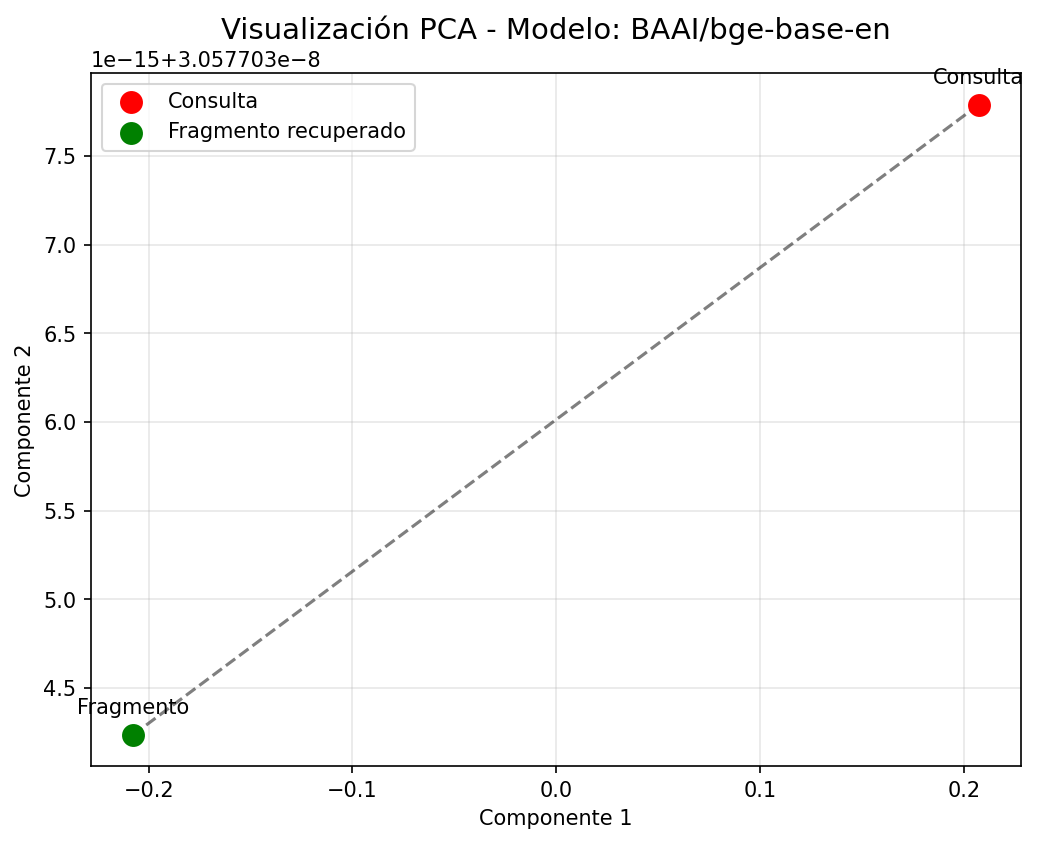


**Modelo: all-MiniLM-L6-v2**


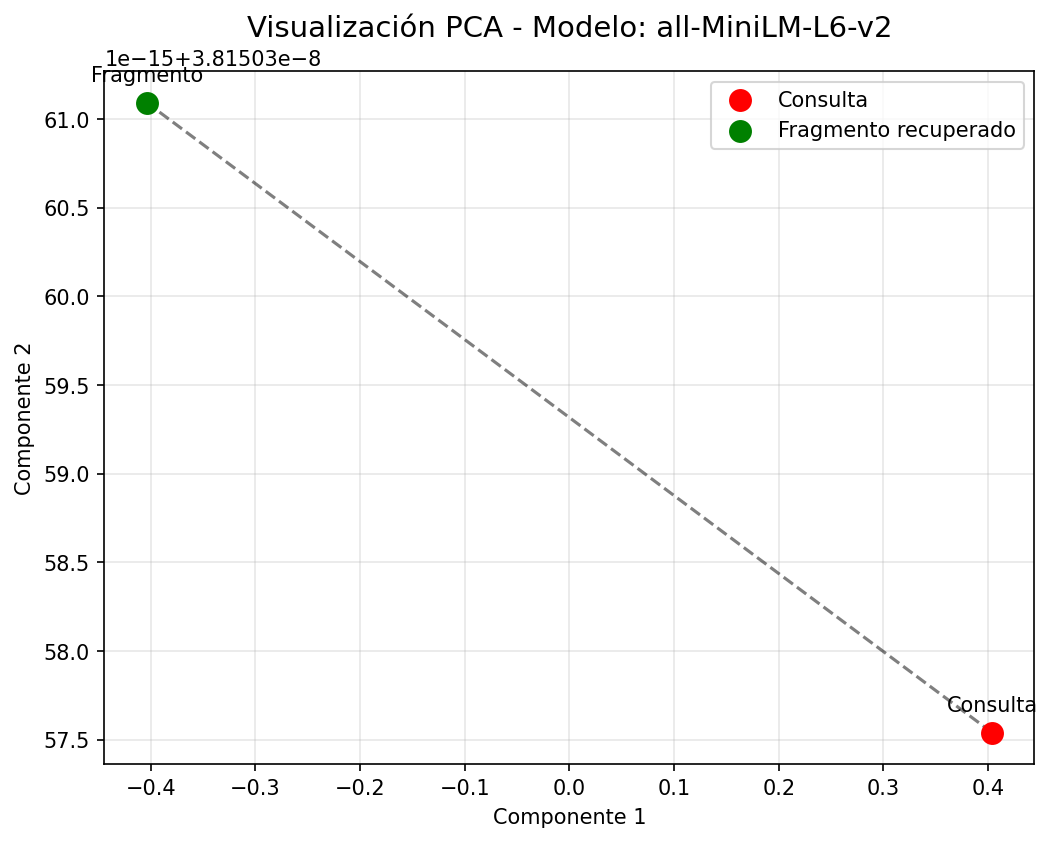


**Modelo: all-mpnet-base-v2**


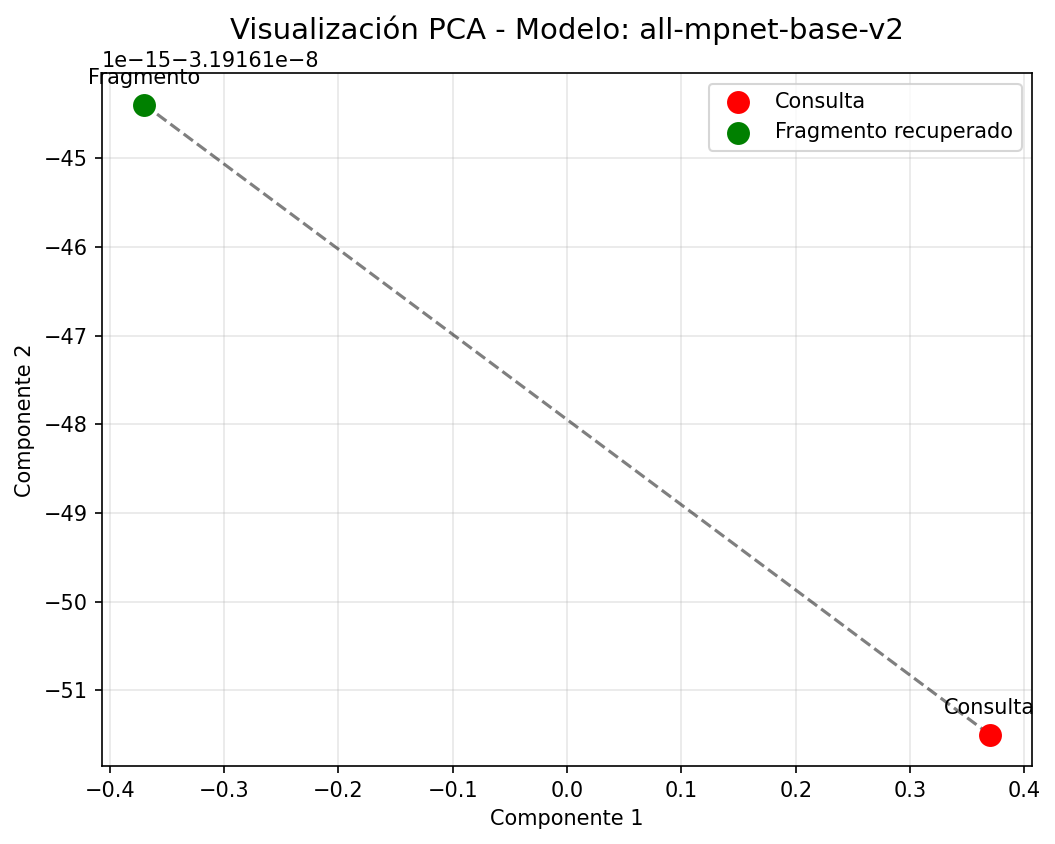


**Modelo: paraphrase-multilingual-MiniLM-L12-v2**


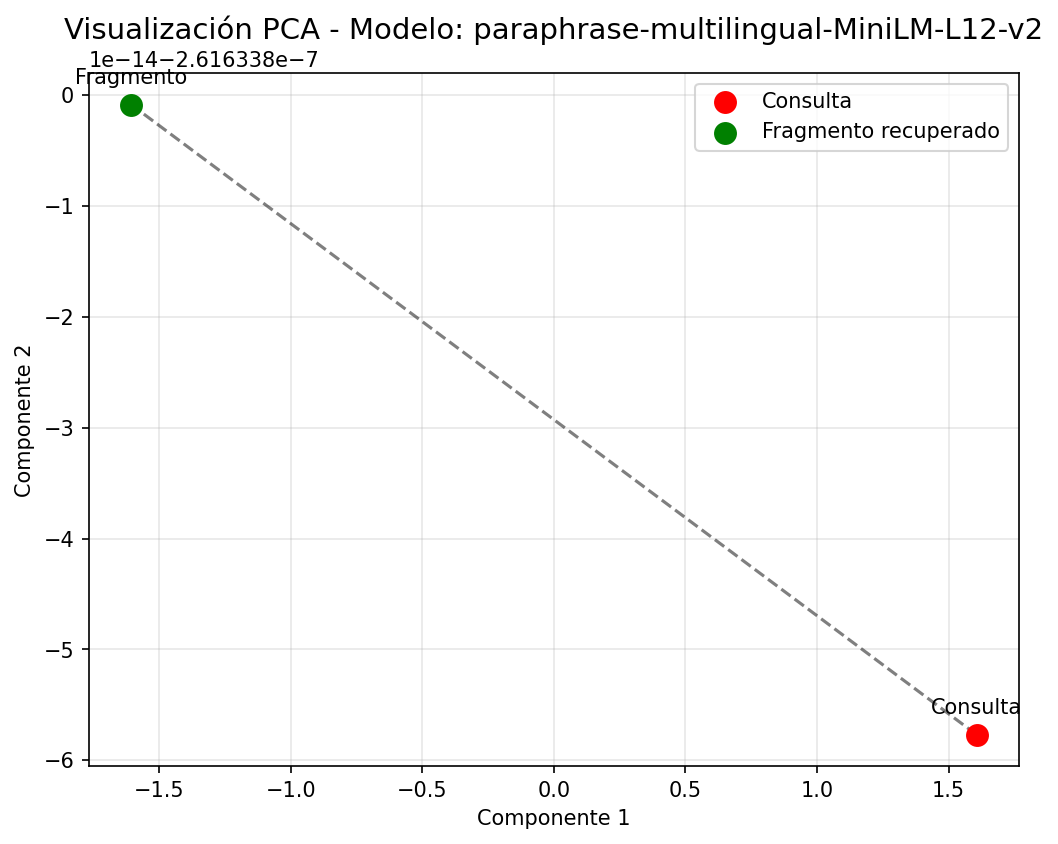

In [ ]:
print("MOSTRANDO GRÁFICAS GENERADAS")

import os
from IPython.display import Image, display, HTML

GRAFICOS_DIR = "/content/graficos_pca"

# Listar todos los archivos PNG en la carpeta
graficos = [f for f in os.listdir(GRAFICOS_DIR) if f.endswith('.png')]
graficos.sort()  # Ordenar alfabéticamente

if not graficos:
    print("No se encontraron gráficos")
else:
    print(f"Encontrados {len(graficos)} gráficos:")
    for i, grafico in enumerate(graficos, 1):
        print(f"   {i}. {grafico}")

    # Mostrar cada gráfico con título
    for grafico in graficos:
        modelo_nombre = grafico.replace("pca_", "").replace(".png", "").replace("__", "/")
        print(f"\n**Modelo: {modelo_nombre}**")

        # Mostrar imagen
        ruta_imagen = os.path.join(GRAFICOS_DIR, grafico)
        display(Image(filename=ruta_imagen, width=700))